This notebook associates estimates of woody area index (WAI) early season measurements from NEON sites to other dates at the same sites found in the master NEON reference measurement database produced by Harry Morris and Luke Brown.

Input WAI estimates are produced using HEMIPy applied to manually classification of the same DHP images used for producing the master database.

All paths ae hardcoded to Richard's workspace.  You will need to recode them to replicate results.

# Modules

In [5]:
#Modules
import pandas as pd
import imageio as iio
import zipfile
from zipfile import ZipFile
from PIL import Image
from PIL import ImageFilter
from PIL import ImageChops
import numpy as np
import glob, exifread
import os
import shutil
import hemipy
import hemipynew
import pickle
import pathlib
import seaborn as sns
import uncertainties
from uncertainties import unumpy

In [ ]:
#Code to make WAI estimates from hemipy - includes flexibility for dilation or skeletonization of inputs

#Reads zip archives of caneye LAI and PAI images and binarizes them
#Will dilate or shrink them using a specified window
#You need to give a threshold but 0 is fine
def read_CANEYE_images_fromzip(file_path,threshold=0,window=1,dilate=False,invert=False):
    img_dict = {}
    input_zip = ZipFile(file_path)
    if dilate:
        for img_name in input_zip.infolist():
            if ( window != 0 ):
                img_dict[img_name.filename] = Image.open(input_zip.open(img_name)).convert('L').point( lambda p: 255 if p == threshold else 0 ) \
                                                .filter(ImageFilter.BoxBlur(window)).point( lambda p: 255 if p >0 else 0 ).convert('1')
            else:
                img_dict[img_name.filename] = Image.open(input_zip.open(img_name)).convert('L').point( lambda p: 255 if p == threshold else 0 ).convert('1')
        
    else:
        for img_name in input_zip.infolist():
            if ( window != 0):
                img_dict[img_name.filename] = Image.open(input_zip.open(img_name)).convert('L').point( lambda p: 255 if p == threshold else 0 ) \
                                                .filter(ImageFilter.BoxBlur(window)).point( lambda p: 255 if p ==255 else 0 ).convert('1')
            else:
                img_dict[img_name.filename] = Image.open(input_zip.open(img_name)).convert('L').point( lambda p: 255 if p == threshold else 0 ).convert('1')
            
    if invert:
        for img_name in input_zip.infolist():
            img_dict[img_name.filename] = ImageChops.invert(img_dict[img_name.filename] )
            
    return img_dict

    
#Make WAI images frm CANEYE processed PAi and LAI images found in a dirctory
#Place the WAI images in a zip archive parallel to the PAI and LAI images
#Assumes only one set of LAI and PAI CANEYE directories are present)
#Returns a dictioar of the WAI images for debugging
def make_wai_images(input_dir,output_dir_suffix,zenith_img_dict,azimuth_img_dict,threshold=0,window_lai=1,dilate_lai=False, window_pai=1,dilate_pai=False,invert=False):
    
    #locate and loop through measurement plots
    plot = input_dir
    
    #extract archive of images
    pai_file_path = list(glob.glob(plot + '/*_PAI/*.zip'))
    pai_img_dict = read_CANEYE_images_fromzip(pai_file_path[0],threshold=0,window=window_pai,dilate=dilate_pai,invert=invert)
    lai_file_path = list(glob.glob(plot + '/*_LAI/*.zip'))
    if lai_file_path:
        lai_img_dict = read_CANEYE_images_fromzip(lai_file_path[0],threshold=0,window=window_lai,dilate=dilate_lai,invert=invert)
        #only keep matching LAI and PAI images
        temp_img_dict = {}
        for img in lai_img_dict:
            try: 
                temp_img_dict[img] = pai_img_dict[img]
            except:
                flag = 1
        pai_img_dict = temp_img_dict
        temp_img_dict = {}
        for img in pai_img_dict:
            try: 
                temp_img_dict[img] = lai_img_dict[img]
            except:
                flag = 1
        lai_img_dict = temp_img_dict  
    else:
        lai_img_dict = {}
        for img in pai_img_dict:
            lai_img_dict[img] = ImageChops.constant(pai_img_dict[img],0).convert('1')

  

    # Creat WAI images , save to a directory named CE_P190_WAI parallel to PAI directory
    wai_img_dict = {}
    wai_file_path = plot+'/WAI'+output_dir_suffix
    pai_file_path = plot+'/PAI'+output_dir_suffix
    lai_file_path = plot+'/LAI'+output_dir_suffix

    # print(wai_file_path)
    os.mkdir(wai_file_path)
    os.mkdir(lai_file_path)
    os.mkdir(pai_file_path)
    for img in pai_img_dict:
        wai_img_dict[img] = (ImageChops.logical_and(ImageChops.invert(lai_img_dict[img]),(pai_img_dict[img])))
        height=wai_img_dict[img].height
        width=wai_img_dict[img].width
        wai_img_dict[img].save(wai_file_path+"/"+img)
        pai_img_dict[img].save(pai_file_path+"/"+img)
        lai_img_dict[img].save(lai_file_path+"/"+img)
    # Zip the wai directory and delete it after
    # shutil.make_archive(plot+"/CE_P180_TIF_WAI", 'zip', wai_file_path)
    # shutil.rmtree(wai_file_path)
    result = {}
    result['wai'] = hemipynew.process( height, width, img_dir=wai_file_path, zenith=zenith_img_dict[height], azimuth=azimuth_img_dict[height] , img_date='2022-07-07', \
                            lat=45,direction = 'up', min_zenith = 0, max_zenith = 60, zenith_bin = 30, azimuth_bin = 30, fcover_zenith = 10, \
                            mask = 90, down_factor = 1 , pai_sat = 4, solar_time = 10, use_miller_rings = False, pre_process_raw = True, \
                            ignore_zeros = False, save_bin_img = False)

    return result

In [6]:
# parses hemipy output into a DF of samples
def create_wai_samples_DF(filename):
    with open(filename+'.pkl', "rb") as f:
        samples_Dict= pickle.load(f)
    samples_DF = pd.DataFrame(samples_Dict.items(),columns=["path_wai","wai_dict"+filename])

    #drop non compliant paths
    samples_DF = samples_DF[~samples_DF['path_wai'].str.contains("NEON_data")]

    #CORRECT BAD PATHS EXPLICTLY
    samples_DF['path_wai'] = samples_DF['path_wai'].apply(lambda x: x.replace("guan","GUAN"))
    
    #determine path head names to parse site and date
    samples_DF['path_head_wai'] = samples_DF['path_wai'].apply(lambda x: x[14:18])


    # # parse paths to get site and date and plot id
    samples_DF.loc[samples_DF['path_head_wai']!="NEON",'SITE'] = samples_DF.loc[samples_DF['path_head_wai']!="NEON"]['path_wai'].apply(lambda x: x[14:18])
    samples_DF.loc[samples_DF['path_head_wai']=="NEON",'SITE'] = samples_DF.loc[samples_DF['path_head_wai']=="NEON"]['path_wai'].apply(lambda x: x[23:27])

    samples_DF.loc[samples_DF['path_head_wai']!="NEON",'PLOT_ID'] = samples_DF.loc[samples_DF['path_head_wai']!="NEON"].apply(lambda x:  x['SITE']+'_0'+x['path_wai'][31:33],axis=1)
    samples_DF.loc[samples_DF['path_head_wai']=="NEON",'PLOT_ID'] = samples_DF.loc[samples_DF['path_head_wai']=="NEON"].apply(lambda x: x['SITE']+'_'+x['path_wai'][x['path_wai'].find('JPG')-4:x['path_wai'].find('JPG')-1],axis=1)


    samples_DF.loc[samples_DF['path_head_wai']!="NEON",'datetime'] = (samples_DF.loc[samples_DF['path_head_wai']!="NEON"].apply(lambda x: x['path_wai'][19:29].replace( '_' , '-'),axis=1))
    samples_DF.loc[samples_DF['path_head_wai']=="NEON",'datetime'] = (samples_DF.loc[samples_DF['path_head_wai']=="NEON"].apply(lambda x: x['path_wai'][ x['path_wai'].find(x['SITE']+'_')+5:x['path_wai'].find(x['SITE']+'_')+15].replace( '_' , '-'),axis=1))
    samples_DF['datetime'] = pd.to_datetime(samples_DF['datetime']).apply(lambda x : x.strftime("%d/%m/%Y") )
    
    return samples_DF.drop(['path_head_wai'],axis=1)



# Generaing WAI estimates using HEMIPY with Richard's CANEYE Classifications (dont run this)

In [ ]:
#Produce WAI images from hemipy
#This will only work if you have the CANEYE output archive so dont run it otherwise.

#Make dictionaries of zenith and azimuth angle images we will need
#These ones are for 180 degree classified woody area images
zenith_img_dict_180 = {}
zenith_img_dict_180[2295] = hemipy.zenith(np.array([2295,2295]), np.array([2295/2,2295/2]),np.array([ 0, 0 ,  180/2295]), down_factor = 1)
zenith_img_dict_180[1608] = hemipy.zenith(np.array([1608,1608]), np.array([1608/2,1608/2]),np.array([ 0, 0 ,  180/1608]), down_factor = 1)
zenith_img_dict_180[1875] = hemipy.zenith(np.array([1875,1875]), np.array([1875/2,1875/2]),np.array([ 0, 0 ,  180/1875]), down_factor = 1)
zenith_img_dict_180[1967] = hemipy.zenith(np.array([1967,1967]), np.array([1967/2,1967/2]),np.array([ 0, 0 ,  180/1967]), down_factor = 1)
zenith_img_dict_180[1337] = hemipy.zenith(np.array([1337,1337]), np.array([1337/2,1337/2]),np.array([ 0, 0 ,  180/1337]), down_factor = 1)

azimuth_img_dict_180 = {}
azimuth_img_dict_180[2295] = hemipy.azimuth(np.array([2295,2295]), np.array([2295/2,2295/2]), down_factor = 1)
azimuth_img_dict_180[1608] = hemipy.azimuth(np.array([1608,1608]), np.array([1608/2,1608/2]), down_factor = 1)
azimuth_img_dict_180[1875] = hemipy.azimuth(np.array([1875,1875]), np.array([1875/2,1875/2]), down_factor = 1)
azimuth_img_dict_180[1967] = hemipy.azimuth(np.array([1967,1967]), np.array([1967/2,1967/2]), down_factor = 1)
azimuth_img_dict_180[1337] = hemipy.azimuth(np.array([1337,1337]), np.array([1337/2,1337/2]), down_factor = 1)

#Produce dictionary of sites and wai estimates from hemipy
#This will iterate over all subdirectories with valid CANEYE classifications of PAI and LAI
#This will also produce output directories of hemipy compatible PAI, LAI and WAI binary images
wai_result_0_0_180={}
for Fullpath in  pathlib.Path('D:/NEONCANEYE').rglob('*_PAI/*.zip'):
    print(Fullpath)
    try: 
        result_0_0_180[str(Fullpath)] = make_wai_images(str(Fullpath.parents[1]),'_0_0_120',zenith_img_dict_120,azimuth_img_dict_120,threshold=0,window_lai=0,dilate_lai=True, window_pai=0,dilate_pai=False,invert=False)
    except:
        result_0_0_180[str(Fullpath)] = {}
with open('result_0_0_180.pkl', 'wb') as handle:
    pickle.dump(result_0_0_180, handle)


# Attaching WAI to NEON PAI (run this after putting the NEON csv file and the wai result from running hemipy in the local directory)

In [7]:
# Read in all NEON data and extract pai and keep only overstory plots
df_NEON = pd.read_csv('NEON_2013-22_RMs_updated.csv')
df_NEON['pai_Miller_overstory'] = df_NEON['true_LAI_Miller_overstory'].apply(lambda x: unumpy.nominal_values(uncertainties.ufloat_fromstr(x)))
df_NEON['pai_Warren_overstory'] = df_NEON['true_LAI_Warren_overstory'].apply(lambda x: unumpy.nominal_values(uncertainties.ufloat_fromstr(x)))
df_NEON = df_NEON.loc[df_NEON['pai_Warren_overstory']>=0]

In [24]:
# read in the wai data set and only select columns we need for future use (we dont need SITE! but should keep date time 
df_NEON_wai = create_wai_samples_DF('result_0_0_180').rename(columns={'path_wai':'path'})

df_NEON_wai['wai_Miller_overstory'] = df_NEON_wai['wai_dictresult_0_0_180'].apply(lambda x: unumpy.nominal_values(x['wai']['pai_miller']))
df_NEON_wai['wai_Warren_overstory'] = df_NEON_wai['wai_dictresult_0_0_180'].apply(lambda x: unumpy.nominal_values(x['wai']['pai_hinge']))
df_NEON_wai['wai_average_overstory'] = (df_NEON_wai['wai_Miller_overstory'] + df_NEON_wai['wai_Warren_overstory'] )/2


In [26]:
#CASE 1 - joing matching samples to NEON RM and compute adjusted wau
df_NEON_case1 = pd.merge(df_NEON,df_NEON_wai,how='inner',on=['PLOT_ID','datetime']).rename(columns={'nlcd_x':'nlcd','SITE_x':'SITE',})


In [27]:
#Case 2 sample with closest PAI at same site, by default this also matches for same plot id 
# Find WAI to closet PAI for same site with same NLCD type
#Make sure to keep date time, plot id and the pai of the wai sample
df_NEON_case2 = pd.DataFrame()
for site in df_NEON_case1['SITE'].unique():
    df_site_case = df_NEON_case1.loc[df_NEON_case1['SITE']==site]
    for NLCD in df_site_case['nlcd'].unique():
        df_wai = df_NEON_case1.loc[df_NEON_case1['nlcd']==NLCD][['pai_Warren_overstory','wai_Warren_overstory','wai_Miller_overstory','wai_average_overstory']].sort_values(['pai_Warren_overstory'])
        df_pai = df_NEON.loc[(df_NEON['SITE']==site) & (df_NEON['nlcd']==NLCD)].sort_values(['pai_Warren_overstory'])
        df_NEON_case2 = pd.concat([df_NEON_case2,pd.merge_asof(df_pai,df_wai,on='pai_Warren_overstory',direction='backward').reset_index()],axis=0)

In [29]:
#Merge case 1 and 2 and get woody area ratio
df_NEON_all = pd.concat([df_NEON_case1,df_NEON_case2]).drop_duplicates(subset=['PLOT_ID','datetime'],keep='first')
df_NEON_all['pai_average_overstory'] = (df_NEON_all['pai_Warren_overstory'] + df_NEON_all['pai_Miller_overstory'])/2
df_NEON_all['ratio_warren'] = (df_NEON_all['wai_Warren_overstory'] / df_NEON_all['pai_Warren_overstory'])
df_NEON_all['ratio_Miller'] = (df_NEON_all['wai_Miller_overstory'] / df_NEON_all['pai_Miller_overstory'])
df_NEON_all['ratio_average'] = (df_NEON_all['wai_average_overstory'] / df_NEON_all['pai_average_overstory'])

In [30]:
#This abby site is wrongly labelled in the NEON database I think should be shrub or deciduous broadleag
print(df_NEON_case1.loc[df_NEON_case1['nlcd']=='grasslandHerbaceous']['PLOT_ID'])

65    ABBY_069
Name: PLOT_ID, dtype: object


<Axes: xlabel='wai_Warren_overstory', ylabel='wai_Miller_overstory'>

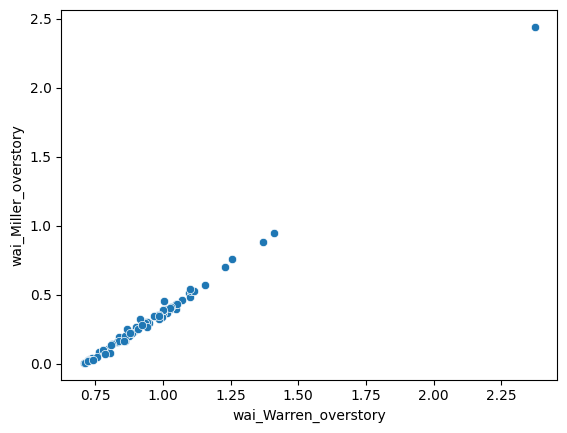

In [20]:
#Warren vs Miller WAI, 
# Miller WAI will underestimate true WAI for sparse canopies as it weights between gap crowns too much
sns.scatterplot(data=df_NEON_case1.dropna(),x='wai_Warren_overstory',y='wai_Miller_overstory')

(0.0, 1.0)

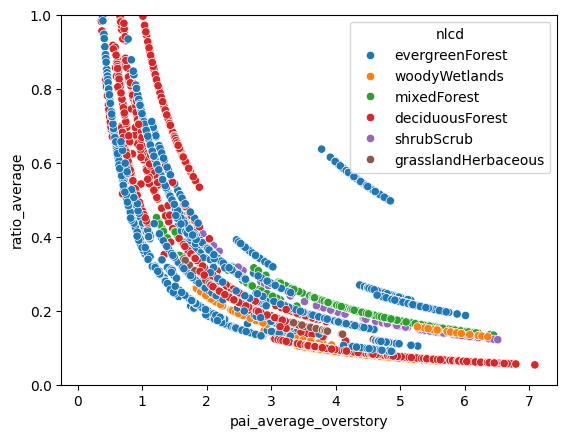

In [31]:
#wai to pai ratio using average of miller and warren
ax = sns.scatterplot(data=df_NEON_all.replace([np.inf, -np.inf], np.nan).dropna(subset=['pai_average_overstory','ratio_average']),x='pai_average_overstory',y='ratio_average',hue='nlcd')
ax.set_ylim([0,1])

<Axes: xlabel='pai_average_overstory', ylabel='wai_average_overstory'>

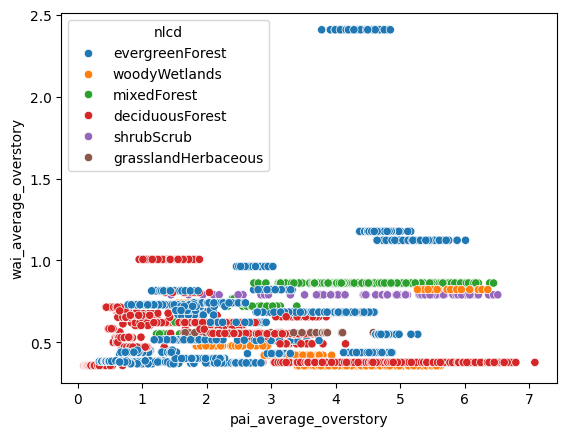

In [32]:
#wai vs pai ratio using average of miller and warren
#note cases of low PAI where WAI can exceed PAI due to assumption WAI is constant for given LAI in site and HEMIPy uncertainty

sns.scatterplot(data=df_NEON_all.dropna(subset=['pai_average_overstory','wai_average_overstory']),x='pai_average_overstory',y='wai_average_overstory',hue='nlcd')
